In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from Loader.ReadCSV import Reader


In [2]:
data = Reader.read_file(timeframe="H1").dropna()[["Open","High","Low","Close"]]
data.head()

,Open,High,Low,Close
datetime,,,,
2023-05-01 00:00:00,1.10106,1.10143,1.10045,1.10055
2023-05-01 01:00:00,1.10055,1.10084,1.10020,1.10040
2023-05-01 02:00:00,1.10037,1.10081,1.10007,1.10081
2023-05-01 03:00:00,1.10081,1.10140,1.10053,1.10140
2023-05-01 04:00:00,1.10143,1.10143,1.10032,1.10062


In [3]:
from feature_engineering.pipelines.AlphaPlusPipeline import ap_pipeline_x_expanded
data_features = ap_pipeline_x_expanded.fit_transform(data).dropna()
data_features.head()

,Open,High,Low,Close,aws_5_34,kma_10_2_20,ppo_26_12_9,roc_12,rsi_14,srsi_14_3_4,srsi_14_3_4_d,srsi_14_3_4_k,bbh_50_2.0,bbl_50_2.0,bbh_15_1.5,bbl_15_1.5
datetime,,,,,,,,,,,,,,,,
2023-05-03 01:00:00,1.10173,1.10240,1.10128,1.10227,0.002543,1.100370,0.079393,0.724638,65.320631,1.000000,0.967294,1.000000,1.102948,1.095071,1.102602,1.096089
2023-05-03 02:00:00,1.10228,1.10258,1.10197,1.10253,0.002822,1.100759,0.089982,0.419885,66.244846,1.000000,0.988093,1.000000,1.103088,1.095011,1.103015,1.096445
2023-05-03 03:00:00,1.10252,1.10297,1.10251,1.10294,0.003132,1.101297,0.100217,0.299186,67.706396,1.000000,0.998436,1.000000,1.103267,1.094933,1.103246,1.097203
2023-05-03 04:00:00,1.10294,1.10294,1.10212,1.10216,0.003296,1.101392,0.101438,0.198185,62.189603,0.517817,0.959818,0.839272,1.103355,1.094899,1.102717,1.098775
2023-05-03 05:00:00,1.10217,1.10263,1.10182,1.10200,0.003334,1.101436,0.100076,0.207326,61.089996,0.421709,0.871445,0.646509,1.103396,1.094882,1.102678,1.099358


In [32]:
def df_to_X_y(df, window_size=5, max_periods = 20,sl=0.001,tp=0.001):
    df_as_np=df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        #row=[a for a in df_as_np[i:i+window_size]]
        X.append(df_as_np[i])

        open_price = df_as_np[i+window_size][3]
        sl_price = open_price*(1-sl)
        tp_price = open_price*(1+tp)
        hist = df_as_np[i+window_size:i+window_size+max_periods]
        val=[0]
        for i in hist:
            current_price=i[3]
            if current_price>tp_price:
                val=[1]
                break
            elif current_price<sl_price:
                break
        y.append(val)

    return np.array(X),np.array(y)
X,y=df_to_X_y(data_features)

In [33]:
print(len(y))
print(sum(y))

3063
[1477]


In [34]:
def separate(X,y,pct_train=0.7,pct_val=0.1):
    pivot_train = int(len(X)*pct_train)
    pivot_val = int(len(X)*(pct_val+pct_train))
    X_train = X[:pivot_train]
    y_train = y[:pivot_train]
    X_val = X[pivot_train:pivot_val]
    y_val=y[pivot_train:pivot_val]
    X_test = X[pivot_val:]
    y_test=y[pivot_val:]
    return X_train,y_train,X_val,y_val,X_test,y_test

X_train,y_train,X_val,y_val,X_test,y_test = separate(X,y)


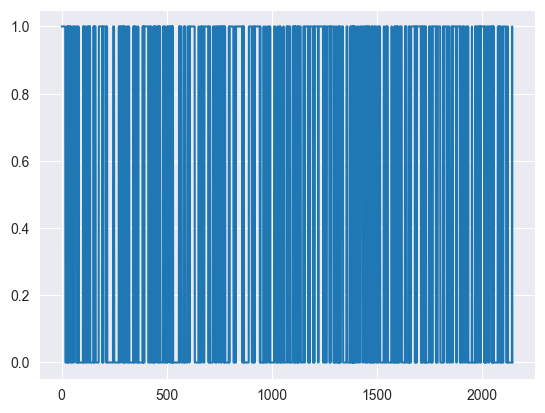

In [35]:
plt.plot(y_train)
plt.show()

In [57]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score


model = SVC(kernel='rbf', C=1.0, gamma='scale')


In [58]:
model.fit(X_train,y_train)

C:\Users\mi compu\Desktop\Programacion\python\FXMLlab\venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

Validation Accuracy: 0.5588235294117647


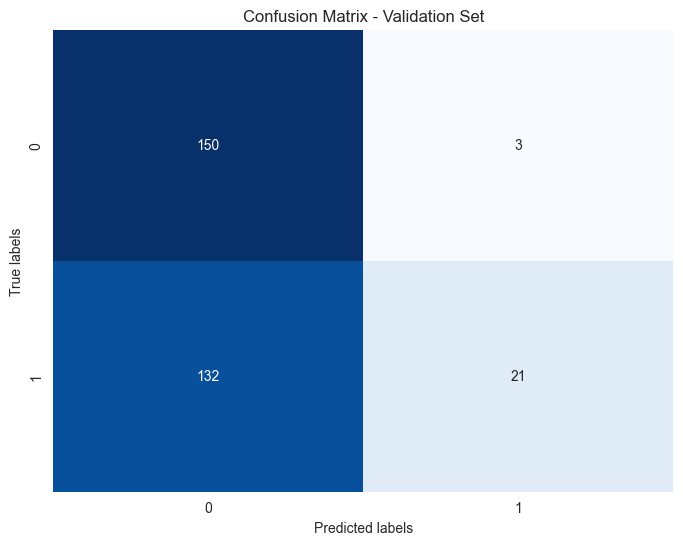

In [59]:
import seaborn as sns
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)
cm = confusion_matrix(y_val, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

Validation Accuracy: 0.5154975530179445


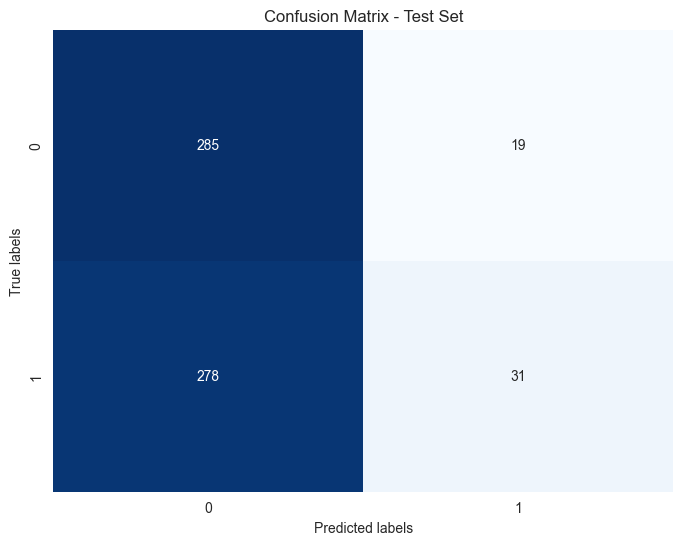

In [60]:
import seaborn as sns
test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Validation Accuracy:", test_accuracy)
cm = confusion_matrix(y_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

Text(0.5, 1.0, 'Model fitting performance')

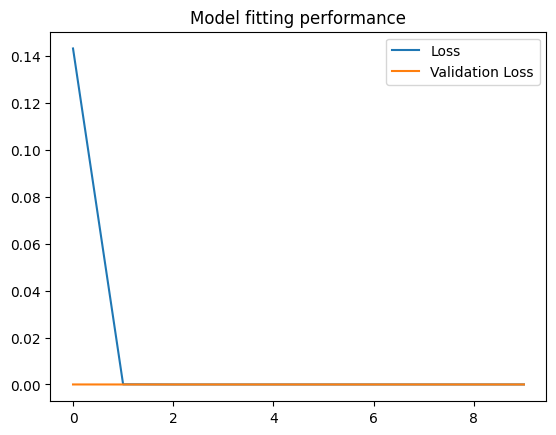

In [19]:
axes=plt.axes()
axes.plot(pd.DataFrame(model.history.history)['loss'], label='Loss')
axes.plot(pd.DataFrame(model.history.history)['val_loss'], label='Validation Loss')
axes.legend(loc=0)
axes.set_title('Model fitting performance')

In [20]:
model1=load_model('model1/')

67/67 [==============================] - 1s 8ms/step


Text(0.5, 1.0, 'Prediction adjustment Train')

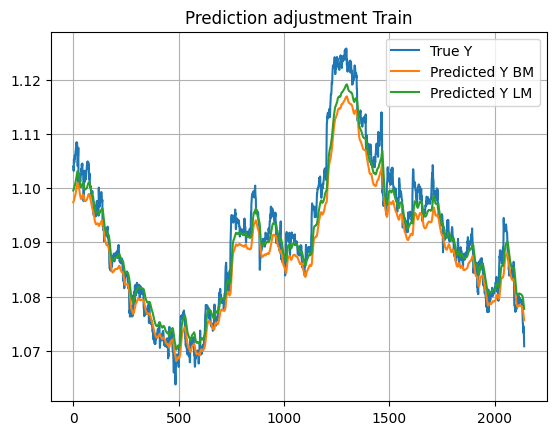

In [21]:
Y_train_predicted_best_model=model1.predict(X_train)
Y_train_predicted_last_model=model.predict(X_train)
Y_train_true=(y_train.reshape(y_train.shape[0],1))
axes=plt.axes()
axes.plot(Y_train_true, label='True Y')
axes.plot(Y_train_predicted_best_model, label='Predicted Y BM')
axes.plot(Y_train_predicted_last_model, label='Predicted Y LM')
axes.legend(loc=0)
axes.grid()
axes.set_title('Prediction adjustment Train')

10/10 [==============================] - 0s 10ms/step


Text(0.5, 1.0, 'Prediction adjustment Validation')

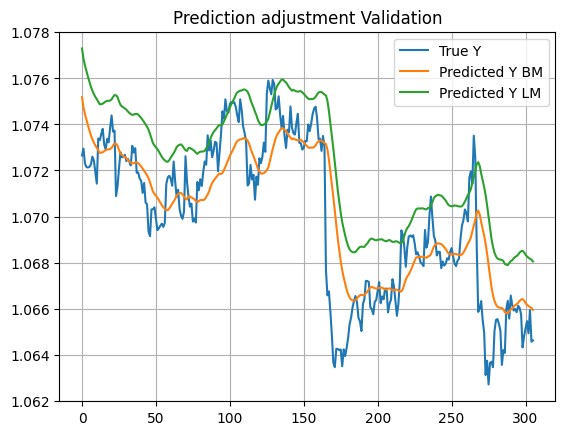

In [22]:
Y_val_predicted_best_model=model1.predict(X_val)
Y_val_predicted_last_model=model.predict(X_val)
Y_val_true=(y_val.reshape(y_val.shape[0],1))
axes=plt.axes()
axes.plot(Y_val_true, label='True Y')
axes.plot(Y_val_predicted_best_model, label='Predicted Y BM')
axes.plot(Y_val_predicted_last_model, label='Predicted Y LM')
axes.legend(loc=0)
axes.grid()
axes.set_title('Prediction adjustment Validation')

In [23]:
Y_predicted_best_model=model1.predict(X_test)
Y_predicted_last_model=model.predict(X_test)
Y_true=(y_test.reshape(y_test.shape[0],1))

20/20 [==============================] - 0s 8ms/step


Text(0.5, 1.0, 'Prediction adjustment Test')

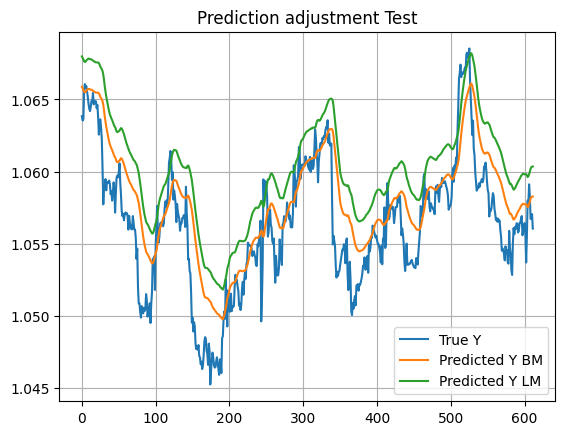

In [24]:
zoom = slice(None) #0,100
axes=plt.axes()
axes.plot(Y_true[zoom], label='True Y')
axes.plot(Y_predicted_best_model[zoom], label='Predicted Y BM')
axes.plot(Y_predicted_last_model[zoom], label='Predicted Y LM')
axes.legend(loc=0)
axes.grid()
axes.set_title('Prediction adjustment Test')

Text(0.5, 1.0, 'Prediction adjustment Test')

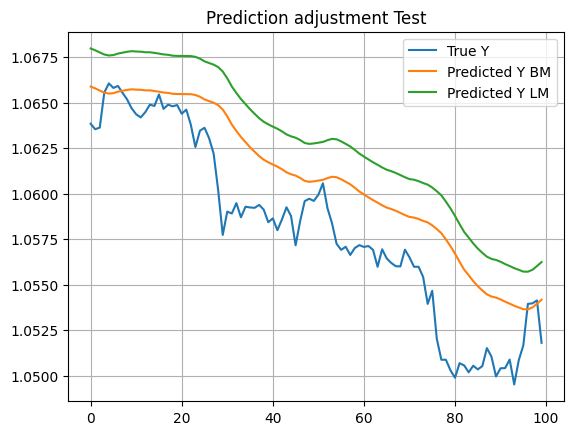

In [25]:
zoom = slice(0,100) #0,100
axes=plt.axes()
axes.plot(Y_true[zoom], label='True Y')
axes.plot(Y_predicted_best_model[zoom], label='Predicted Y BM')
axes.plot(Y_predicted_last_model[zoom], label='Predicted Y LM')
axes.legend(loc=0)
axes.grid()
axes.set_title('Prediction adjustment Test')